Reference: [Ultralytics YoloV5 github repository](https://github.com/ultralytics/yolov5)

# Imports

In [1]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests #to download some data from internet
import random
import numpy as np

SEED = 42
np.random.seed(SEED)

In [2]:
!pwd

/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection


## Prepare the Dataset


Dataset for Summer 2022 competition Source: [HBRS Bib cloud](https://bib-cloud.bib.hochschule-bonn-rhein-sieg.de/apps/files/?dir=/Shared/b-it-bots-ds/atwork/images/object_detection/YOLO/internal_robocup_2022/FULL_DATASET_SS22_COMPETITION&fileid=14231157)

The dataset is structured in the following manner:

```
├── dataset_ss22_v4.yaml
├── README.md
├── dataset_ss22_v4
        train
        ├── images
        └── labels
        valid
        ├── images
        └── labels

```

### The Dataset YAML File

The dataset YAML (`dataset_ss22_v4.yaml`) file containing the path to the training and validation images and labels. This file will also contain the class names from the dataset.

The dataset contains 20 classes.

The following block shows the contents of the `dataset_ss22_v4.yaml` file.

```yaml
train: ../dataset_ss22_v4/train/images
val: ../dataset_ss22_v4/valid/images

nc: 20

names: ['F20_20_B', 'R20', 'S40_40_B', 'S40_40_G', 'axis', 'bearing_box', 'bracket', 'brown_box', 'cup', 'dishwasher_soap', 'eye_glasses', 'insulation_tape', 'motor', 'pringles', 'screw_driver', 'sponge', 'spoon', 'tennis_ball', 'toothbrush', 'towel']
```

### Visualize a Few Ground Truth Images

In YOLO format, [x_center, y_center, width, height]


```
A------------------------
-------------------------
-------------------------
-------------------------
-------------------------
------------------------B
```

In Bounding Box format, A [x_min, y_min] and B [x_max, y_max].


Visualize 4 random samples from Dataset

[Reference](https://www.youtube.com/watch?v=Ciy1J97dbY0&ab_channel=LearnOpenCV)

In [3]:
class_names = ['F20_20_B', 'R20', 'S40_40_B', 'S40_40_G', 'axis', 'bearing_box', 'bracket', 'brown_box', 'cup', 
               'dishwasher_soap', 'eye_glasses', 'insulation_tape', 'motor', 'pringles', 'screw_driver', 'sponge', 
               'spoon', 'tennis_ball', 'toothbrush', 'towel']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [4]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [5]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin

        class_name = class_names[int(labels[box_num])]

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        )

        font_scale = min(1, max(3, int(w/500)))
        font_thickness = min(2, max(10, int(w/50)))

        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name,
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image,
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image,
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [6]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()

    num_images = len(all_training_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0, num_images-1)
        # j = 0
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line.split(' ')[0]
                bbox_string = label_line.split(' ')[1:]
                x_c, y_c, w, h = bbox_string
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h.split('\n')[0])
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()


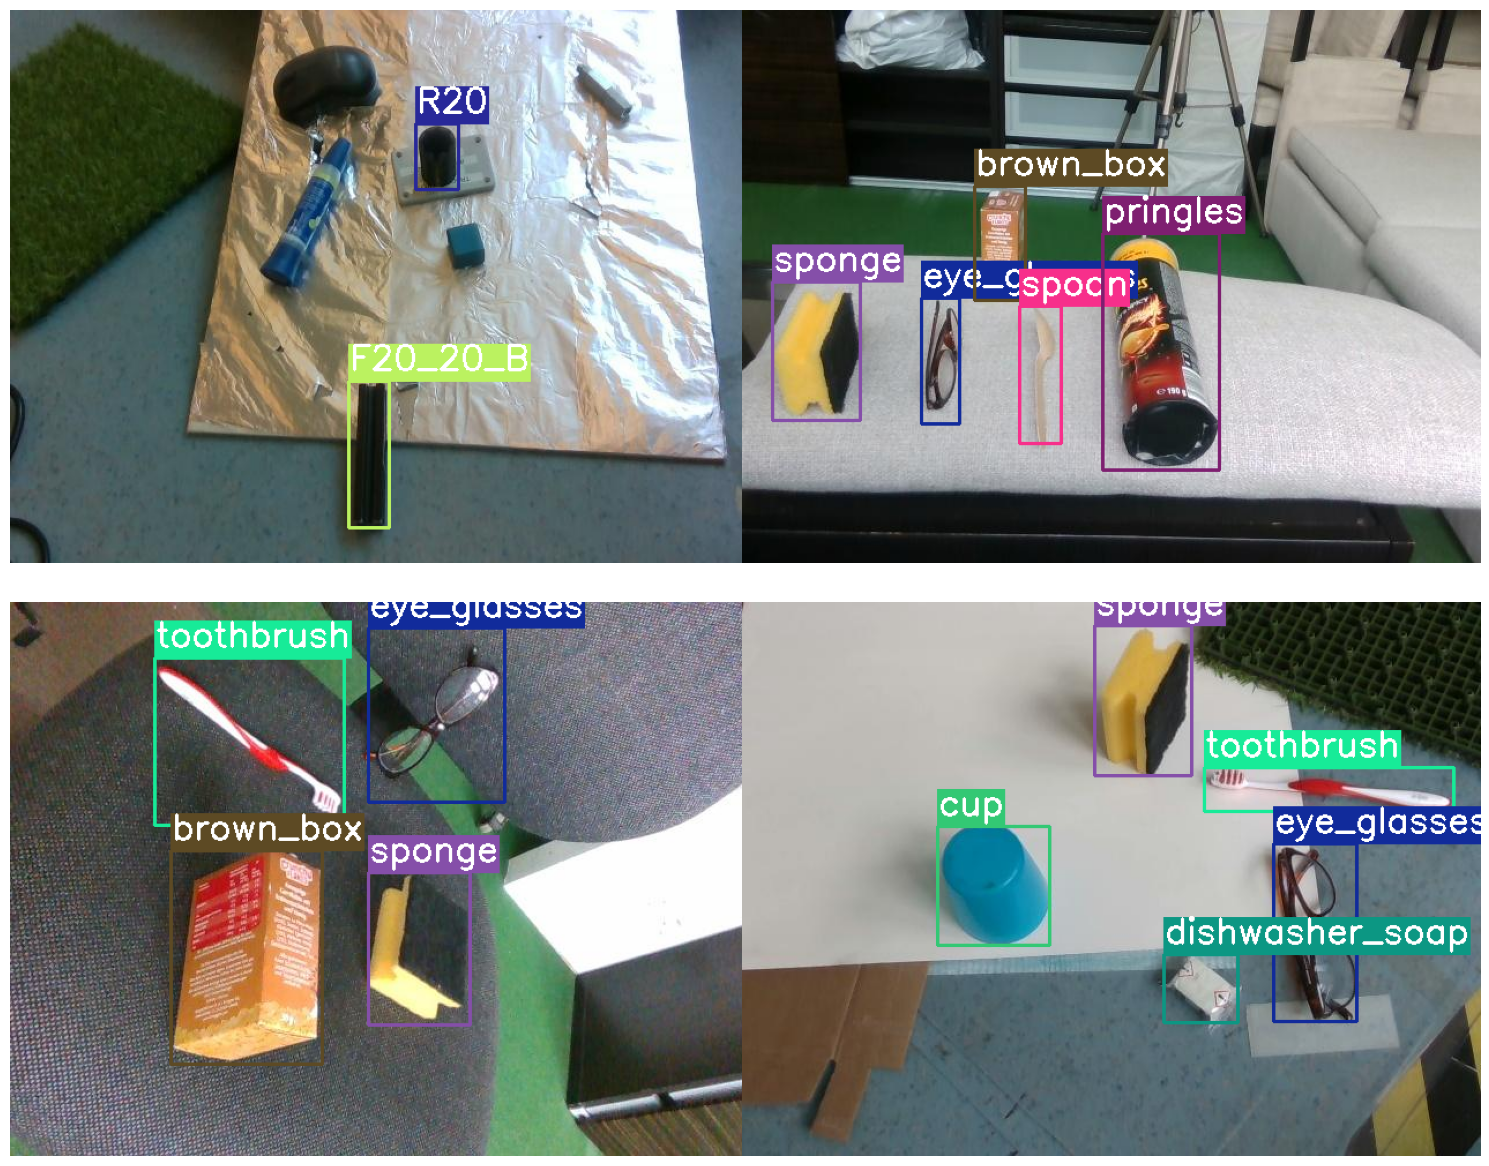

In [7]:
# Visualize a few training images.
plot(
    image_paths='dataset_ss22_v4/train/images/*', 
    label_paths='dataset_ss22_v4/train/labels/*',
    num_samples=4,
)

# plot(
#     image_paths='dataset_ss22_inference/train/images/*', 
#     label_paths='dataset_ss22_inference/train/labels/*',
#     num_samples=4,
# )

## Helper Functions for Logging

The helper functions are for logging of the results in the notebook while training the models.


In [ ]:
def set_res_dir():
    # Directory to store results
    #res_dir_count = len(glob.glob('runs/train/*'))
    res_dir_count = len(glob.glob('/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/logs/yolov5/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/logs/yolov5/train/results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/logs/yolov5/train/results_{res_dir_count}"
    return RES_DIR

## YOLOv8 Code

In [ ]:
# install ultralytics yolov8
!pip install ultralytics

### Train a YOLOv8 Model

In [3]:
# Inputs and Hyperparameters for training
data_yaml = f"/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/dataset_ss22_v4.yaml"
epochs = 10
batch_size = 16
image_size = 640
model_name = "yolov8_ss22_v4"
cuda_devices = [0,1] # GPU devices ids 
freeze_layers = '0, 1, 2, 3, 4, 5' # Layer ids to freeze

In [4]:
        # !python -m torch.distributed.run --nproc_per_node 2 train.py \
        #         --batch 512 \ DONE
        #         --data ../dataset_ss22_v4.yaml \ DONE
        #         --weights yolov5m.pt \ 
        #         --img 640 \ DONE
        #         --epochs {EPOCHS} \ DONE
        #         --name {RES_DIR} \ DONE
        #         --device 0,1 \ DONE
        #         --freeze 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14

In [5]:
from ultralytics import YOLO

# Load a model
# model = YOLO('yolov8n.yaml')  # build a new model from YAML
model = YOLO('yolov8n.pt')  # load a pretrained model (recommended for training)
# model = YOLO('yolov8n.yaml').load('yolov8n.pt')  # build from YAML and transfer weights

# Train the model
model.train(data=data_yaml,  # dataset.yaml 
            epochs=epochs,
            imgsz=image_size,
            batch=batch_size,
            name=model_name,
            device=cuda_devices,
            )


Ultralytics YOLOv8.0.112 🚀 Python-3.8.16 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24268MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/dataset_ss22_v4.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8_ss22_v4, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

## **Function to Monitor TensorBoard logs**

**NOTE**: TensorBoard logs can be visualized with [Local port link](http://10.20.118.78:31025/#scalars&runSelectionState=eyJ5b2xvNS90cmFpbi9yZXN1bHRzXzEiOmZhbHNlLCJ5b2xvNS90cmFpbi9yZXN1bHRzXzIiOmZhbHNlLCJ5b2xvNS90cmFpbi9yZXN1bHRzXzMiOmZhbHNlLCJ5b2xvNS90cmFpbi9yZXN1bHRzXzQiOmZhbHNlLCJ5b2xvNS90cmFpbi9yZXN1bHRzXzUiOmZhbHNlLCJ5b2xvNS90cmFpbi9yZXN1bHRzXzgiOmZhbHNlLCJ5b2xvNS90cmFpbi9yZXN1bHRzXzgyIjpmYWxzZSwieW9sbzUvdHJhaW4vcmVzdWx0c18xNCI6ZmFsc2UsInlvbG81L3RyYWluL3Jlc3VsdHNfMTMiOmZhbHNlLCJ5b2xvNS90cmFpbi9yZXN1bHRzXzEyIjpmYWxzZSwieW9sbzUvdHJhaW4vcmVzdWx0c18xMSI6ZmFsc2V9)


## Training using YOLOV5

In [ ]:
TRAIN = True
FREEZE = True # freezing first 15 layers
EPOCHS = 10

##### If already trained model (.pt file) is available, then give that model path in `--weights` argument
Note: User configurable arguments
- batch size
- data yaml path
- pre-trained weight file
- image size
- epochs
- result directory
- freeze layers

In [ ]:
def freeze_layer(trainer):
    model = trainer.model
    num_freeze = 10
    print(f"Freezing {num_freeze} layers")
    freeze = [f'model.{x}.' for x in range(num_freeze)]  # layers to freeze 
    for k, v in model.named_parameters(): 
        v.requires_grad = True  # train all layers 
        if any(x in k for x in freeze): 
            print(f'freezing {k}') 
            v.requires_grad = False 
    print(f"{num_freeze} layers are freezed.")

In [ ]:
model = YOLO("yolov8n.pt")
model.add_callback("on_train_start", freeze_layer)
model.train(data="/home/tapendra/Desktop/config/data.yaml", epochs=2, batch=2)

In [ ]:

if TRAIN:   
    if FREEZE:
        RES_DIR = set_res_dir()
    
        # training by freezing first 15 layers out of 25 layers       
#         !python train.py \
#                 --batch 256 \
#                 --data ../dataset_ss22.yaml \
#                 --weights yolov5m.pt \
#                 --img 640 \
#                 --epochs {EPOCHS} \
#                 --name {RES_DIR} \
#                 --freeze 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
        
        # trainig on multi GPUs
        !python -m torch.distributed.run --nproc_per_node 2 /home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/yolov5/train.py \
                --batch 512 \
                --data ../dataset_ss22_v4.yaml \
                --weights yolov5m.pt \
                --img 640 \
                --epochs {EPOCHS} \
                --name {RES_DIR} \
                --device 0,1 \
                --freeze 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
        
        
    
#         # trainig using pretrained model (multi GPUs)
#         !python -m torch.distributed.run --nproc_per_node 2 train.py \
#                 --batch 512 \
#                 --data ../dataset_ss22_v3.yaml \
#                 --resume /home/jovyan/public/logs/yolo5/train/results_22/weights/best.pt \
#                 --img 640 \
#                 --epochs {EPOCHS} \
#                 --name {RES_DIR} \
#                 --device 0,1 \
#                 --freeze 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14
    
    else:
        RES_DIR = set_res_dir()
        # training all layers of model
        !python train.py --data ../dataset_ss22_v2.yaml --weights yolov5m.pt \
        --img 640 --epochs {EPOCHS} --batch-size 256 --name {RES_DIR}
else:
    # set the RES_DIR name
    res_dir_count = '1' 
    RES_DIR = f"/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/logs/yolov5/train/results_{res_dir_count}"
    print("Set RES_DIR to: ", RES_DIR)


## Check Out the Validation Predictions and Inference

### Visualization and Inference Utilities

In [ ]:
# Function to show validation predictions saved during training.
def show_valid_results(RES_DIR):
    !ls {RES_DIR}
    EXP_PATH = f"{RES_DIR}"
    validation_pred_images = glob.glob(f"{EXP_PATH}/*_pred.jpg")
    print(validation_pred_images)
    for pred_image in validation_pred_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

The following functions are for carrying out inference on images and videos.

In [ ]:
# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/logs/yolov5/detect/*'))
    print(f"Current number of inference detection directories: {infer_dir_count}")
    INFER_DIR = f"/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/logs/yolov5/detect/inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Inference on images.
    !python detect.py --weights {RES_DIR}/weights/best.pt \
    --source {data_path} --name {INFER_DIR} --device 0
    return INFER_DIR

In [ ]:
def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}/*")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

**Visualize validation prediction images.**

In [ ]:
show_valid_results(RES_DIR)

### Inference
In this section, we will carry out inference on unseen images and videos from the internet. 

The images for inference are in the `inference_images` directory.

**To carry out inference on images, we just need to provide the directory path where all the images are stored, and inference will happen on all images automatically.**

In [ ]:
on_single_image = True

if on_single_image:
    # Inference on single image
    IMAGE_INFER_DIR = inference(RES_DIR, '/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/test_imgs/rgb_raw_1662123101.237838.jpg')
else:
    # Inference on images.
    IMAGE_INFER_DIR = inference(RES_DIR, '/home/kpatel2s/kpatel2s/b_it_bots/2d_object_detection/yolo-object-detection/test_imgs')


IMAGE_INFER_DIR

In [ ]:
# IMAGE_INFER_DIR
visualize(IMAGE_INFER_DIR)

# Export model (.pt) to ONNX model (.onnx)
###### Reference: https://learnopencv.com/object-detection-using-yolov5-and-opencv-dnn-in-c-and-python/

In [ ]:
!python export.py --weights /home/jovyan/public/logs/yolo5/train/results_28/weights/best.pt --include onnx